# **Emotion Recognition in Emergency Call** 

# Importing Libaries

In [2]:

import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
import os
import IPython.display as ipd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

## Reading CSV File

In [3]:
df = pd.read_csv('UrbanSound8K.csv')
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


## Label Collection

In [4]:
df['class'].value_counts()

children_playing    1000
air_conditioner     1000
engine_idling       1000
street_music        1000
drilling            1000
jackhammer          1000
dog_bark            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

### Breaking Audio File Multi 4 Sec Segment

In [5]:
max_length = 4 
desired_sr = 16000
mic_sr = 16000 
desired_samples = max_length*desired_sr 

tf.random.set_seed(0)
np.random.seed(0)
os.environ['PYTHONHASHSEED'] = '0'

## Utility Function

In [6]:
#Processing the data
dataset_min = 0.0
dataset_max = 1.0

def denormalize_dataset(input_val):
  global dataset_min, dataset_max
  return input_val * (dataset_max - dataset_min)

#Function to normalize input values
def normalize_dataset(input_val):
  global dataset_min, dataset_max
  dataset_min = np.min(input_val) 
  dataset_max = np.max(input_val) 

  diff = dataset_max - dataset_min
  if (diff != 0):
    input_val /= diff
  return input_val

def interpolateAudio(audio):
    factor = float(mic_sr)/desired_sr
    x_interp_values = []
    for i in range(len(audio)):
        x_interp_values.append(int(factor*i))
    audio_interpolated = np.interp(range(int(len(audio)*factor)), x_interp_values, audio)

    return mic_sr, audio_interpolated

### **Populate Dataset**

## **Picking the hotwords**

In [7]:
word_dirs = list(set(df['class'].to_list()))
hotwords = ['jackhammer', 'dog_bark', 'siren', 'gun_shot']

print("All words in dataset - \n", ', '.join(word_dirs))
print("\nHotwords - \n", ', '.join(hotwords))

All words in dataset - 
 siren, jackhammer, drilling, car_horn, dog_bark, engine_idling, street_music, gun_shot, air_conditioner, children_playing

Hotwords - 
 jackhammer, dog_bark, siren, gun_shot


## **Handling labels and background samples**

In [8]:
add_noise = False # add different words, null samples and random noise
n_classes = len(hotwords) + int(add_noise) 

class_nSamples = 1000
other_nSamples = float(class_nSamples)/(len(word_dirs) - n_classes)

def nLabel(word):
    return n_classes-1 if ( word not in hotwords ) else hotwords.index(word)

def textLabel(index):
    return hotwords[index] if index <len(hotwords) else "background"

def sampleBackGround():
    return add_noise

### **Creating the dataset**

In [9]:
#Dataset storing audio samples for wake word and background

top_dir = "audio"

input_audio   = np.empty((0, desired_samples)).astype(np.float32)
input_labels  = np.empty((0)).astype(np.int32); # index of the word in hotwords list is the lable.

for word in (word_dirs) :
    print("\n",word)
    
    if ( word not in hotwords and False == sampleBackGround()) : # background, do not include
        print("-- Background/noise/other words not included")
        continue
        
    else: # to be included
        dfx = df[df['class'] == word]
        start_time = time.time()

        wav_files = 0

        word_samples = np.empty((0, desired_samples))
        
        if word in hotwords: # hotwords
            print("-- Category : hotword")
            
            for i in range(len(dfx)):
                file_path ="fold" + str(dfx.iloc[i]['fold']) + "/" + str(dfx.iloc[i]['slice_file_name'])

                X_sub = np.empty((0, desired_samples))
                X, sr = librosa.core.load(file_path, sr=desired_sr)
                X, interval = librosa.effects.trim(X)

                if X.shape[0] < desired_sr: # if samples less than 1 second
                    continue

                if X.shape[0]%desired_samples != 0: # if it needs padding, else, there will be unnecessary silence appended
                    X = np.pad(X, (0, desired_samples - (X.shape[0]%desired_samples)))
                
                X_sub = np.array(np.split(X, int(X.shape[0]*1.0/desired_samples)))
                
                word_samples = np.append(word_samples, X_sub, axis=0)

                if ( word_samples.shape[0] > class_nSamples ):
                    break

                wav_files = wav_files + 1
            
        else:
            print("-- Category : backgound/noise/other words")

            for i in range(len(dfx)):
                file_path ="fold" + str(dfx.iloc[i]['fold']) + "/" + str(dfx.iloc[i]['slice_file_name'])

                X, sr = librosa.core.load(file_path, sr=desired_sr)
                X, interval = librosa.effects.trim(X)
                X = np.pad(X, (0,desired_samples - (X.shape[0]%desired_samples)))
                X_sub = np.array(np.split(X, int(X.shape[0]*1.0/desired_samples)))

                word_samples = np.append(word_samples, X_sub, axis=0)

                if ( word_samples.shape[0] > other_nSamples ):
                    break
                
                wav_files = wav_files + 1
            
        if ( word_samples.size > 0 ):
            input_audio = np.concatenate((input_audio, word_samples), axis=0)
            labels = np.full((word_samples.shape[0]), nLabel(word))
            input_labels = np.concatenate((input_labels, labels))

            print("added {} audio files with {} samples for word \"{}\" with label {} in {:.1f} sec.".
                  format(wav_files, labels.shape[0], word, nLabel(word), (time.time() - start_time)))


 siren
-- Category : hotword
added 915 audio files with 915 samples for word "siren" with label 2 in 223.6 sec.

 jackhammer
-- Category : hotword
added 978 audio files with 978 samples for word "jackhammer" with label 0 in 261.9 sec.

 drilling
-- Background/noise/other words not included

 car_horn
-- Background/noise/other words not included

 dog_bark
-- Category : hotword
added 863 audio files with 863 samples for word "dog_bark" with label 1 in 220.0 sec.

 engine_idling
-- Background/noise/other words not included

 street_music
-- Background/noise/other words not included

 gun_shot
-- Category : hotword
added 269 audio files with 269 samples for word "gun_shot" with label 3 in 38.3 sec.

 air_conditioner
-- Background/noise/other words not included

 children_playing
-- Background/noise/other words not included


# **Concatenating dataset into matrix of inputs and labels**

In [10]:
onehot_labels = np.zeros((input_labels.size, n_classes)).astype(np.int32)
onehot_labels[np.arange(input_labels.size), input_labels] = 1

input_labels = onehot_labels
print("Input dataset size:", input_audio.shape)
print("Input targets size:", input_labels.shape)

Input dataset size: (3025, 64000)
Input targets size: (3025, 4)


## **Adding noise/silence as background**

In [11]:
if ( sampleBackGround() ) :
    n_bg_samples = int(other_nSamples)

    bg_labels    = np.zeros((n_bg_samples, n_classes)).astype(np.int)
    bg_labels[:,n_classes-1] = 1

    silence = np.zeros((n_bg_samples, desired_samples))
    input_audio = np.append(input_audio, silence, axis=0)
    input_labels = np.append(input_labels, bg_labels, axis=0)
    
    background = np.zeros((n_bg_samples, desired_samples))
    input_audio = np.append(input_audio, background, axis=0)
    input_labels = np.append(input_labels, bg_labels, axis=0)

## **Extracting STFT features**

In [12]:
fft_len = 2048
win_len = fft_len
hop_len = int(win_len/4)

def spectrogramOp(X):
  # STFT returns np.ndarray of shape=(1 + fft_len/2, t)
  spectrogram_out = librosa.core.stft(X, n_fft=fft_len, hop_length=hop_len, win_length=win_len, center=True)
#  spectrogram_out = np.swapaxes(np.abs(spectrogram_out), 0, 1)
  return np.absolute(spectrogram_out)

#inputs = np.array([spectrogramOp(input) for input in input_audio])
input_spectrogram = np.empty((input_audio.shape[0], int(fft_len/2 + 1), int(desired_samples/hop_len + 1))).astype(np.float32)

i = 0 ;
for input in input_audio:
    input_spectrogram[i] = spectrogramOp(input) 
    i = i +  1
print("input dataset size:", input_spectrogram.shape)

input dataset size: (3025, 1025, 126)


## **Normalize**

In [13]:
input_spectrogram = normalize_dataset(input_spectrogram)

## **Train-test split**

In [14]:
total_len = input_labels.shape[0]

#Shuffling inputs and labels
shuffle_permutation = np.arange(total_len)
np.random.shuffle(shuffle_permutation)

input_spectrogram = input_spectrogram[shuffle_permutation]
input_labels = input_labels[shuffle_permutation]

#Splitting into train and test dataset - 90-10 ratio
train_split = 0.9
cutoff = int(train_split*total_len)

inputs_train = input_spectrogram[:cutoff]
inputs_test = input_spectrogram[cutoff:]
labels_train = input_labels[:cutoff]
labels_test = input_labels[cutoff:]

## **Play using inverse-STFT**

Label : jackhammer


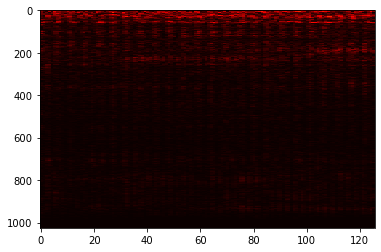

In [15]:
#Selecting random index from test dataset

ind = int(np.random.uniform()*len(inputs_train))

#Displaying sample spectrogram and audio from test dataset
X = inputs_train[ind]
y = labels_train[ind].argmax()
print("Label :", textLabel(y) )
plt.imshow(X, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()
audio = librosa.core.istft(X, hop_length=hop_len, win_length=win_len)

ipd.Audio(audio, rate=desired_sr, autoplay=True)

In [16]:
model = tf.keras.Sequential()

# (None, 126, 65)  = batch_inputs_train.shape. Replace the numbers from inputs_train, if it changes.
# 126 = int(desired_samples/hop_len + 1), = time axis
# 65  = int(fft_len/2 + 1) = freq bins

lambda1 = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, int(fft_len/2 + 1), int(desired_samples/hop_len + 1), 1)), 
                                 name="add_channels", batch_input_shape=(None, int(fft_len/2 + 1), int(desired_samples/hop_len + 1)))
conv2d1 = tf.keras.layers.Conv2D(16, (int(fft_len/2 + 1), 4), strides=1, activation='relu', name="conv1", 
                                 batch_input_shape=(int(fft_len/2 + 1), int(desired_samples/hop_len + 1), 1))
conv2d2 = tf.keras.layers.Conv2D(32, (1, 4), strides=4, activation='relu', name="conv2")
conv2d3 = tf.keras.layers.Conv2D(64, (1, 4), strides=3, activation='relu', name="conv3")
flatten1 = tf.keras.layers.Flatten()
dense1  = tf.keras.layers.Dense(6*n_classes)
dense2  = tf.keras.layers.Dense(n_classes)
dropout = tf.keras.layers.Dropout(0.2)
activation1 = tf.keras.layers.Activation('softmax')

model.add(lambda1)
model.add(conv2d1)
model.add(conv2d2)
model.add(conv2d3)
model.add(flatten1)
model.add(dense1)
model.add(dense2) 
model.add(dropout)
model.add(activation1)

model.compile(optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy'],
              loss=(tf.keras.losses.binary_crossentropy if (n_classes==2) else tf.keras.losses.categorical_crossentropy))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 add_channels (Lambda)       (None, 1025, 126, 1)      0         
                                                                 
 conv1 (Conv2D)              (None, 1, 123, 16)        65616     
                                                                 
 conv2 (Conv2D)              (None, 1, 30, 32)         2080      
                                                                 
 conv3 (Conv2D)              (None, 1, 9, 64)          8256      
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 24)                13848     
                                                                 
 dense_1 (Dense)             (None, 4)                 1

## CNN Model 

In [17]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights = True)]
model.fit(inputs_train, labels_train, batch_size=64, epochs=1024, callbacks=callbacks, validation_data=(inputs_test, labels_test))

Epoch 1/1024
43/43 [==============================] - 7s 144ms/step - loss: 0.8986 - accuracy: 0.5977 - val_loss: 0.6981 - val_accuracy: 0.7492
Epoch 2/1024
43/43 [==============================] - 7s 162ms/step - loss: 0.6586 - accuracy: 0.7300 - val_loss: 0.6198 - val_accuracy: 0.7921
Epoch 3/1024
43/43 [==============================] - 7s 164ms/step - loss: 0.5338 - accuracy: 0.7866 - val_loss: 0.5266 - val_accuracy: 0.8416
Epoch 4/1024
43/43 [==============================] - 7s 159ms/step - loss: 0.5141 - accuracy: 0.8090 - val_loss: 0.6076 - val_accuracy: 0.8317
Epoch 5/1024
43/43 [==============================] - 6s 141ms/step - loss: 0.4621 - accuracy: 0.8112 - val_loss: 0.5464 - val_accuracy: 0.8713
Epoch 6/1024
43/43 [==============================] - 7s 156ms/step - loss: 0.3823 - accuracy: 0.8486 - val_loss: 0.4313 - val_accuracy: 0.9076
Epoch 7/1024
43/43 [==============================] - 7s 155ms/step - loss: 0.3310 - accuracy: 0.8626 - val_loss: 0.4722 - val_accuracy:

43/43 [==============================] - 6s 136ms/step - loss: 0.1096 - accuracy: 0.9526 - val_loss: 0.4271 - val_accuracy: 0.9637
Epoch 58/1024
43/43 [==============================] - 6s 140ms/step - loss: 0.1032 - accuracy: 0.9500 - val_loss: 0.3907 - val_accuracy: 0.9637
Epoch 59/1024
43/43 [==============================] - 8s 182ms/step - loss: 0.1208 - accuracy: 0.9471 - val_loss: 0.4369 - val_accuracy: 0.9604
Epoch 60/1024
43/43 [==============================] - 8s 194ms/step - loss: 0.1316 - accuracy: 0.9434 - val_loss: 0.5479 - val_accuracy: 0.9340
Epoch 61/1024
43/43 [==============================] - 8s 188ms/step - loss: 0.4632 - accuracy: 0.8696 - val_loss: 0.3242 - val_accuracy: 0.9109
Epoch 62/1024
43/43 [==============================] - 7s 174ms/step - loss: 0.1855 - accuracy: 0.9243 - val_loss: 0.3545 - val_accuracy: 0.9406
Epoch 63/1024
43/43 [==============================] - 7s 169ms/step - loss: 0.1599 - accuracy: 0.9309 - val_loss: 0.3860 - val_accuracy: 0.9439

## Evaluation

In [18]:
model.evaluate(inputs_test, labels_test)

10/10 [==============================] - 0s 24ms/step - loss: 0.2729 - accuracy: 0.9373


[0.2728953957557678, 0.9372937083244324]

### Model Saving 

In [19]:
model.save("audio.h5")

# Prediction

## On Random Sample

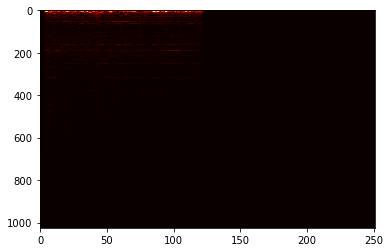

The true labels are: car_horn


In [45]:
n = 1 # number of samples

X, y = [], []
top_dir = "audio"

for i in range(n):
    i = int(np.random.uniform()*len(df))
    file_path = file_path ="fold" + str(df.iloc[i]['fold']) + "/" + str(df.iloc[i]['slice_file_name'])
    
    audio, sr = librosa.core.load(file_path, sr=desired_sr, mono=True)
    audio, interval = librosa.effects.trim(audio, top_db=30)
    audio = np.pad(audio, int((desired_samples-audio.shape[0])/2))
    X = np.append(X, audio)
    y.append(df.iloc[i]['class'])


X = np.pad(X, (0, desired_samples - (X.shape[0]%desired_samples)))

assert sr == desired_sr #ensure sample rate is same as desired
assert len(X.shape) == 1 #ensure X is a mono signal

spectrogram_out = spectrogramOp(X)
plt.imshow(spectrogram_out, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

print("The true labels are:", ', '.join(y))

ipd.Audio(X, rate=sr, autoplay=True)

## Confusion Matrix

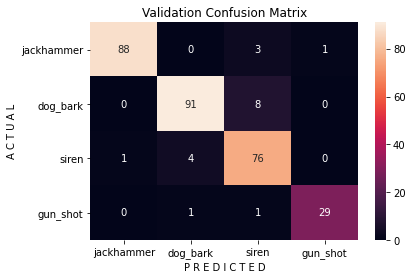

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions_test = model.predict(inputs_test)
cm = confusion_matrix(labels_test.argmax(axis=1), predictions_test.argmax(axis=1))

tck_labels = hotwords+["noise"] if ( sampleBackGround() ) else hotwords
sns.heatmap(cm, xticklabels=tck_labels, yticklabels=tck_labels, annot=True,fmt="d",)
plt.title("Validation Confusion Matrix")
plt.ylabel("A C T U A L")
plt.xlabel("P R E D I C T E D")
plt.show()

# On Background and Silence

In [22]:
background = spectrogramOp(np.random.random((desired_samples)))
silence = spectrogramOp(np.zeros((desired_samples)))
background_out, silence_out = model.predict(np.array([background, silence]))
print("Predicted ", textLabel(background_out.argmax()), "on random audio with vector", background_out)
print("Predicted ", textLabel(silence_out.argmax()), "on null audio with vector", silence_out)

Predicted  jackhammer on random audio with vector [1. 0. 0. 0.]
Predicted  siren on null audio with vector [0.00470781 0.10799366 0.8855805  0.00171806]


# On Longer Clips

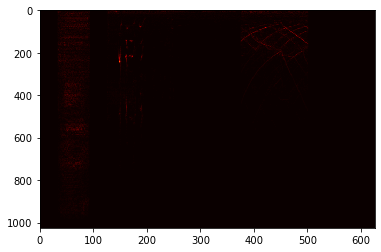

The true labels are: jackhammer, children_playing, street_music, siren


In [46]:
n = 4 # number of samples

X, y = [], []
top_dir = "audio"

for i in range(n):
    i = int(np.random.uniform()*len(df))
    file_path = file_path ="fold" + str(df.iloc[i]['fold']) + "/" + str(df.iloc[i]['slice_file_name'])
    
    audio, sr = librosa.core.load(file_path, sr=desired_sr, mono=True)
    audio, interval = librosa.effects.trim(audio, top_db=30)
    audio = np.pad(audio, int((desired_samples-audio.shape[0])/2))
    X = np.append(X, audio)
    y.append(df.iloc[i]['class'])


X = np.pad(X, (0, desired_samples - (X.shape[0]%desired_samples)))

assert sr == desired_sr #ensure sample rate is same as desired
assert len(X.shape) == 1 #ensure X is a mono signal

spectrogram_out = spectrogramOp(X)
plt.imshow(spectrogram_out, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

print("The true labels are:", ', '.join(y))

ipd.Audio(X, rate=sr, autoplay=True)

In [ ]:
ind = int(np.random.uniform()*len(inputs_test))
spectrogram_out = inputs_test[ind]

ipd.Audio(spectrogram_out, rate=desired_sr)

y = labels_test[ind]
output = model.predict(np.expand_dims(np.array([inputs_test[ind]]), 0))

print("True label:", textLabel(np.argmax(y)))
print("Prediction:", textLabel(np.argmax(output)))

plt.imshow(spectrogram_out, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

audio = librosa.core.istft(spectrogram_out, hop_length=hop_len, win_length=win_len)
playback_sr, audio_interpolated = interpolateAudio(audio)
ipd.Audio(audio_interpolated, rate=playback_sr, autoplay=True)